In [1]:
import igraph
import numpy as np
import json
import random
import pickle
import matplotlib.pyplot as plt

In [2]:
skip1 = 0
data = {}
for line in open("san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv"):
    csv_row = line.split(',')
    if (skip1 == 1):
        if (csv_row[2] == '12'):
            #print (csv_row[0], csv_row[1], csv_row[3])
            k1 = int (csv_row[0])
            k2 = int(csv_row[1])
            if (k1 <= k2):
                key = (k1, k2)
            else:
                key = (k2, k1)
            if (not (key in data.keys())):
                data[key] = []
            data[key].append(float(csv_row[3]))                
    skip1 = 1
    
#['sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time']

In [3]:
print (len(data))

321713


In [4]:
data_tup  = []
for k in data.keys():
    mean_wt = np.mean(data[k])
    data_tup.append((k[0],k[1], mean_wt))
    
#data_np = np.array(data_np)

In [5]:
len(data_tup)

321713

In [6]:
g = igraph.Graph.TupleList(data_tup, directed=False, weights=True)
print (g.summary())
print ("Number of Edges:    " , len(g.get_edgelist()))

IGRAPH UNW- 1905 321713 -- 
+ attr: name (v), weight (e)
Number of Edges:     321713


In [7]:
g = g.clusters().giant()
print (g.summary())
print ("Number of Edges:    " , len(g.get_edgelist()))

IGRAPH UNW- 1898 321703 -- 
+ attr: name (v), weight (e)
Number of Edges:     321703


In [8]:
# Question 6
# Number of Edges = 321703
# Number of Vertices = 1898

In [9]:
with open('san_francisco_censustracts.json', 'r') as infile:  
    geo_data_j = json.load(infile)

In [10]:
vert_feat = {}
for i in range(len(geo_data_j['features'])):
    feat_i = geo_data_j['features'][i]
    m_id = feat_i['properties']['MOVEMENT_ID']
    disp_name = feat_i['properties']['DISPLAY_NAME']
    coors = np.mean(np.array(feat_i['geometry']['coordinates'][0][0]), axis = 0)
    vert_feat[int(m_id)] = (disp_name, coors.tolist())
    #print (m_id, disp_name, coors)

In [11]:
n_v = len(g.vs)
print ("Number of vertices: ", n_v)

for i in range(len(g.vs)):
    ind = g.vs[i]['name']
    g.vs[i]['disp_name'] = vert_feat[ind][0]
    g.vs[i]['coors'] = vert_feat[ind][1]

Number of vertices:  1898


In [12]:
mst = g.spanning_tree()
print (mst.summary())

mst_edges = mst.get_edgelist()[:5]
print(mst_edges)

IGRAPH UNW- 1898 1897 -- 
+ attr: coors (v), disp_name (v), name (v), weight (e)
[(0, 1), (2, 3), (18, 19), (56, 57), (283, 284)]


In [13]:
for (e1,e2) in mst_edges:
    print (g.vs[e1]['disp_name'], g.vs[e2]['disp_name'])
    print (g.vs[e1]['coors'])
    print (g.vs[e2]['coors'])
    print ('\n\n')

2100 Fieldcrest Avenue, Fairfield 100 Monte Verde Drive, Vacaville
[-122.05216156249999, 38.292827187500016]
[-122.00124636111111, 38.352439888888895]



1000 Neilson Street, Albany 800 40th Street, Longfellow, Oakland
[-122.28737978260868, 37.88701856521739]
[-122.27357263157893, 37.83122173684211]



600 San Bruno Avenue East, San Bruno 3700 Rhoda Drive, West San Jose, San Jose
[-122.40644822222224, 37.62803318518518]
[-121.97476406249999, 37.30359775]



700 Lakeville Circle, Petaluma 7700 Lakeville Highway, Petaluma
[-122.59061477777777, 38.2394685]
[-122.54534531698114, 38.218784641509465]



16300 Castello Knolls Drive, Prunedale 800 East Laurel Drive, Salinas
[-121.74466116504854, 36.744977980582526]
[-121.62191814705884, 36.69384788235294]





In [14]:
edge_list = g.get_edgelist()
random.shuffle(edge_list)

In [15]:
vertices = []
#sorted_edges = []
for (e1, e2) in edge_list:
    if (not (e1 in vertices)):
        vertices.append(e1)
    if (not (e2 in vertices)):
        vertices.append(e2)
#     if (e1 > e2):
#         t = e1
#         e1 = e2
#         e2 = e1
#     sorted_edges.append((e1,e2))

In [16]:
len(vertices)

1898

In [17]:
def get_triangles(edge_list):
    triangles = []
    count = 0

    for (v1,v2) in edge_list:
        for v in vertices:
            if (count%100 == 0):
                print (count)
            if (count == 1000):
                return triangles
            if ((((v, v1) in edge_list) or ((v1, v) in edge_list)) and (((v, v2) in edge_list) or ((v2, v) in edge_list)) and (v != v1) and (v != v2)):
                count = count + 1
                triangles.append((v, v1, v2))

In [ ]:
triangles = get_triangles(edge_list)

In [ ]:
f = open("triangles.txt", "wb")
pickle.dump(triangles, f)

In [41]:
f = open("triangles.txt", "rb")
triangles2 = pickle.load(f)

In [42]:
edge_list = g.get_edgelist()
count = 0
for (v1,v2,v3) in triangles2:
    try:
        i1 = edge_list.index((v1,v2))
    except:
        i1 = edge_list.index((v2,v1))
        
    try:
        i2 = edge_list.index((v2,v3))
    except:
        i2 = edge_list.index((v3,v2))
        
    try:
        i3 = edge_list.index((v3,v1))
    except:
        i3 = edge_list.index((v1,v3))
        
    w1 = g.es[i1]['weight']
    w2 = g.es[i2]['weight']
    w3 = g.es[i3]['weight']
    
    if (((w1+w2) >= w3) and ((w2+w3) > w1) and ((w3+w1) > w2)):
        count = count + 1
        
print (count/10.0, "% of the triangles satisfy the triangle inequality.")

92.8 % of the triangles satisfy the triangle inequality.


In [43]:
# Apply the 1-approximate algorithm

In [94]:
mst_double_edges = []
mst_edgelist = mst.get_edgelist()
for i in range(len(mst_edgelist)):
    wt = mst.es[i]['weight']
    (v1, v2) = mst_edgelist[i]
    mst_double_edges.append((mst.vs[v1]['name'], mst.vs[v2]['name'], wt))
    mst_double_edges.append((mst.vs[v1]['name'], mst.vs[v2]['name'], wt))
    
print (len(mst_edgelist))
print (len(mst_double_edges))

1897
3794


In [95]:
# Create two copies of each edge in MST
mst_d = igraph.Graph.TupleList(mst_double_edges, directed=False, weights=True)

In [96]:
n_v = len(mst_d.vs)
print ("Number of vertices in MST Double  : ", n_v)
print ("Number of edges in MST Double     : ", len(mst_d.es))
print ("Number of edges in MST            : ", len(mst.es))

for i in range(len(mst_d.vs)):
    ind = mst_d.vs[i]['name']
    mst_d.vs[i]['disp_name'] = vert_feat[ind][0]
    mst_d.vs[i]['coors'] = vert_feat[ind][1]

Number of vertices in MST Double  :  1898
Number of edges in MST Double     :  3794
Number of edges in MST            :  1897


In [134]:
# Find a eulerian walk of that
count = 0
n_v = len(mst_d.vs)
mst_d_edgelist = mst_d.get_edgelist()
path = []
curr = mst_d_edgelist[0][0]
vertices = [curr]
edges_remaining = list.copy(mst_d_edgelist)

In [135]:
curr_n = -1
while (count < n_v):
    for (v1,v2) in edges_remaining:
        if (v1 == curr or v2 == curr):
            if (count%10 == 0):
                print (count, '/', n_v)
            edges_remaining.remove((v1,v2))
            path.append((v1,v2))
            curr_n = -1
            if (v1 == curr):
                if (not (v2 in vertices)):
                    vertices.append(v2)
                curr_n = v2
            if (v2 == curr):
                if (not (v1 in vertices)):
                    vertices.append(v1)
                curr_n = v1
            break
    if (curr == curr_n):
        print ('No edge found for vertex: ', curr, count)
        break
    curr = curr_n
    count += 1
        

0 / 1898
10 / 1898
20 / 1898
30 / 1898
40 / 1898
50 / 1898
60 / 1898
70 / 1898
80 / 1898
90 / 1898
100 / 1898
110 / 1898
120 / 1898
130 / 1898
140 / 1898
150 / 1898
160 / 1898
170 / 1898
180 / 1898
190 / 1898
200 / 1898
210 / 1898
220 / 1898
230 / 1898
240 / 1898
250 / 1898
260 / 1898
270 / 1898
280 / 1898
290 / 1898
300 / 1898
310 / 1898
320 / 1898
330 / 1898
340 / 1898
350 / 1898
360 / 1898
370 / 1898
380 / 1898
390 / 1898
400 / 1898
410 / 1898
420 / 1898
430 / 1898
440 / 1898
450 / 1898
460 / 1898
470 / 1898
480 / 1898
490 / 1898
500 / 1898
510 / 1898
520 / 1898
530 / 1898
540 / 1898
550 / 1898
560 / 1898
570 / 1898
580 / 1898
590 / 1898
600 / 1898
610 / 1898
620 / 1898
630 / 1898
640 / 1898
650 / 1898
660 / 1898
670 / 1898
680 / 1898
690 / 1898
700 / 1898
710 / 1898
720 / 1898
730 / 1898
740 / 1898
750 / 1898
760 / 1898
770 / 1898
780 / 1898
790 / 1898
800 / 1898
810 / 1898
820 / 1898
830 / 1898
840 / 1898
850 / 1898
860 / 1898
870 / 1898
880 / 1898
890 / 1898
900 / 1898
910 / 1898

In [136]:
def convert_vertex_index(vertices, g, mst):
    vertices_n = []
    for v in vertices:
        n = mst.vs[v]['name']
        for i in range(len(g.vs)):
            if (n == g.vs[i]['name']):
                vertices_n.append(i)
    return vertices_n


def convert_path_index(path, g, mst):
    path_n = []
    for (v1, v2) in path:
        n1 = mst.vs[v1]['name']
        n2 = mst.vs[v2]['name']
        ind1 = -1
        ind2 = -1
        for i in range(len(g.vs)):
            if (n1 == g.vs[i]['name']):
                ind1 = i
            if (n2 == g.vs[i]['name']):
                ind2 = i
        path_n.append((ind1, ind2))
    return path_n

In [137]:
vertices_g = convert_vertex_index(vertices, g, mst_d)
path_g = convert_path_index(path, g, mst_d)

In [138]:
first_mentions = {}
for v in vertices_g:
    for i in range(len(path_g)):
        (e1,e2) = path_g[i]
        if (e1 == v or e2 == v):
            first_mentions[v] = i
            break

In [139]:
path_trimmed = []
cost = 0.0


g_edgelist = g.get_edgelist()

for i in range(0, len(vertices)-1):
    v = vertices[i]
    n_v = vertices[i+1]
    
    v_g = vertices_g[i]
    n_v_g = vertices_g[i+1]
    
    if ((v,n_v) in mst_d_edgelist):
        #print ("Direct edge from mst: ", v, n_v)
        path_trimmed.append((v_g,n_v_g))
        cost += mst_d.es[mst_d_edgelist.index((v,n_v))]['weight']
    elif ((n_v,v) in mst_d_edgelist):
        #print ("Direct edge from mst: ", n_v, v)
        path_trimmed.append((n_v_g,v_g))
        cost += mst_d.es[mst_d_edgelist.index((n_v,v))]['weight']
    elif ((v_g,n_v_g) in g_edgelist):
        #print ("Direct edge from g: ", v_g, n_v_g)
        path_trimmed.append((v_g,n_v_g))
        cost += g.es[g_edgelist.index((v_g,n_v_g))]['weight']
    elif ((n_v_g,v_g) in g_edgelist):
        #print ("Direct edge from g: ", n_v_g, v_g)
        path_trimmed.append((n_v_g,v_g))
        cost += g.es[g_edgelist.index((n_v_g,v_g))]['weight']
    else:
        for i in range(first_mentions[v_g]+1, first_mentions[n_v_g]+1):
            if (path_g[i] in g_edgelist):
                path_trimmed.append(path_g[i])
                cost += g.es[g_edgelist.index(path_g[i])]['weight']
            else:
                opp_e = (path_g[i][1], path_g[i][0])
                path_trimmed.append(opp_e)
                cost += g.es[g_edgelist.index(opp_e)]['weight']
#         e_list = g.get_shortest_paths(v_g, to=n_v_g, weights='weight', output="epath")
#         for e in e_list[0]:
#             path_trimmed.append(g_edgelist[e])
#             cost += g.es[e]['weight']
            
print ("Cost of Approx. TSP = ", cost)

Cost of Approx. TSP =  3061333.004999999


In [140]:
print(len(path), len(path_trimmed))

1898 1512


In [141]:
# Path Cost
cost_path = 0.0
for e in path:
    cost_path += mst_d.es[mst_d.get_edgelist().index(e)]['weight']
    
print ('Cost of Path: ', cost_path)
print ('Cost of Path Trimmed: ', cost)

Cost of Path:  3960869.4899999946
Cost of Path Trimmed:  3061333.004999999


In [142]:
# Find an upper bound on the empirical performance of the approximate algorithm:
# rho = Approximate TSP Cost/Optimal TSP Cost

In [143]:
path_vertices = [path_trimmed[0][0]]
for (v1, v2) in path_trimmed:
    path_vertices.append(v2)

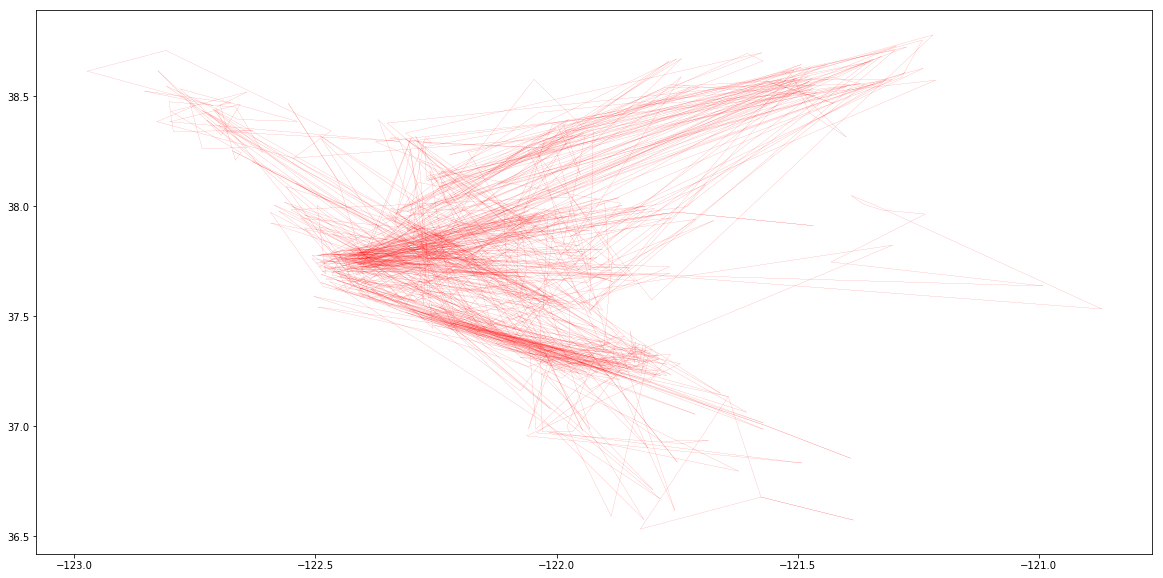

In [146]:
# Plot the trajectory that Santa has to travel!

x = [g.vs[path_trimmed[0][0]]['coors'][0]]
y = [g.vs[path_trimmed[0][0]]['coors'][1]]

for (v1,v2) in path_trimmed:
    x.append(g.vs[v2]['coors'][0])
    y.append(g.vs[v2]['coors'][1])

plt.figure(figsize=(20,10))
for i in range(0,len(x)-1):
    plt.plot(x[i:i+2],y[i:i+2], 'ro-', linewidth=0.1, ms=0)

plt.show()